Here we study how number of pairs change with the sky area of lenses.

In [1]:
# Standard imports
import copy
import corner
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Astropy imports
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.units import Quantity
from astropy import constants as const

# SLSim imports
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.Lenses.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
from slsim.Lenses.lens import Lens
from slsim.LOS.los_pop import LOSPop

# Lenstronomy, HierArc imports
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam

# Fit plane to the data
def fit_plane(x, y, z):
    """Fit a plane to the data points (x, y, z). The plane is z = ax + by + c."""

    # don't use nans or infs
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    A = np.c_[x, y, np.ones_like(x)]
    coeffs, _, _, _ = np.linalg.lstsq(A, z, rcond=None)
    return coeffs

# Find the scatter of the data points from the fitted plane
def find_scatter(x, y, z, coeffs, return_fit=False):
    """Find the scatter of the data points from the fitted plane. Return ``z - z_fit``."""

    # don't use nans or infs
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    z_fit = coeffs[0] * x + coeffs[1] * y + coeffs[2]
    scatter = z - z_fit
    if return_fit:
        return scatter, z_fit
    else:
        return scatter

/Users/paras/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/paras/Projects/repos/self/slsim/slsim/Plots/lens_plots.py:5: UserWarning: If you want to simulate images with Roman filters, please install the galsim module.
Note that this module is not supported on Windows
  from slsim.ImageSimulation.roman_image_simulation import simulate_roman_image


In [2]:
# load the GGL data tables with different sky areas of lenses bu galaxy population is on 10 deg^2
sky_area = "50.0v2"
GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG_RED_DEFLECTOR_BLUE_SOURCE.fits", format='fits')
GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,1.1395730540197462,2.721757883923871,0.6383209474735921,234.52827079090258,408649665972.69635,25.933963738373834,26.127290551620234,26.254675998006924,25.877372770610663,25.77967242684352,22.98925557393261,24.057250718125182,25.178428704908463,22.13937039113474,21.469667400192904,0.5236284022464591,-0.2185177432823041,0.0403576488557333,0.22221328481968317,2,4.30707590221643,6033.914441400326,26.23568913352215
1,1.1676192009673254,2.838231941243875,0.5428598143754139,215.84729996869848,324309245490.47504,24.22762289989987,24.307252461915994,24.330966194829777,24.19614120355442,24.25840995562706,23.4402925996813,24.481996698219838,25.35590571629431,22.647451548717875,21.931126586377424,0.2833098895986966,0.01249637671998382,-0.11601750873715334,0.11668856741216427,2,2.339785570397245,9636.754519164577,25.086016539203026
2,0.8496635018062778,3.3535717429740073,0.641000768077548,198.8149905902349,252718868917.48575,25.559769535693853,25.692328159661358,26.0026527226674,25.435595481739007,25.34701222772341,21.96306329205506,22.827566278001065,23.54640956678392,21.2303460229086,20.962437814004915,0.23774477841756192,0.0316484729535937,0.16867423476209303,0.17161766608619294,2,1.820585794159507,9782.545548619119,22.86143073655398
3,1.5030247928909466,2.1037429248665225,0.5111993143704567,314.13299407421005,883777743495.4609,26.510924542753955,26.70858277146902,27.1583892110041,26.131180343134147,25.81278128068294,23.77862974498593,25.346268769963384,26.00807169213301,22.905058039418602,22.357811050847626,1.4659095665465913,-0.009356050373493305,-0.025632148189255435,0.027286309742933265,2,12.406290085901004,3755.908492949182,29.310824741747
4,0.09931798255962809,2.1700020122674757,0.8909096122755212,182.91937545558415,192914100798.88678,26.068800062516363,26.18260302373776,26.453438870162888,25.85431274554333,25.597538901622872,15.682406808159396,16.184348056972592,17.024734167739563,15.371562734687448,15.1519986272104,1.8882089102964354,-0.03149400430312179,0.020689174501004406,0.03768174954242524,2,3.4613724155333387,993.0878825186128,20.86717108100093
5,0.5288078808555957,4.343158907234654,1.8475198758908336,295.8237930636839,760108618473.295,26.489822086076952,26.713722342261637,27.968750435273822,26.51430656934446,26.36029223477607,18.820681063983304,19.673589738103377,20.940708005983755,18.453013637031862,18.219862227367084,1.3974704615046138,-0.037506289136146086,0.029683186537268865,0.04783109122496046,2,8.783981475448723,4329.28295528526,24.12990678858026
6,1.4559015868937206,3.8947692755843875,0.6865247003713678,244.97777562316497,462966940487.00793,26.6810933315858,26.722212903637512,27.36112014871479,26.47404290286856,26.398807903193074,24.046814542508628,25.29251052208788,25.617233245782813,23.347386960561984,22.7428989776878,0.3386182857665169,-0.03450844210644334,-0.04499833975555973,0.056706993901727315,2,2.862031469438829,11700.201951750312,25.745941106562977
7,0.2806689195320025,1.7410928677555793,0.702790233640981,178.45741656564877,176660221028.014,26.85810971732381,27.019893227146323,27.191141500680875,26.537720058873933,26.28112734684412,18.536060330766365,19.020192408396266,20.210660912850745,18.275044840954653,18.081439214360305,0.5836787330604735,-0.10351118102632655,-0.293874446056699,0.31157142783412706,2,2.481363853666704,2908.161559314505,21.745803937276175
8,0.7706303273274793,4.211551756362357,0.9218938814173087,225.27783876034175,365843003536.67883,26.207415223007033,26.463795844134502,27.56823350434354,26.10852487865217,25.982309600016222,21.08702338199977,22.261540879019485,23.52052383691099,20

In [3]:
# fit the MFP
coeffs_MFP = fit_plane(
    np.log10(GGL_data_table["R_e_kpc"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["sigma_v_D"])
)

# find the scatter
scatter_MFP = find_scatter(
    np.log10(GGL_data_table["R_e_kpc"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["sigma_v_D"]),
    coeffs_MFP,
    return_fit=False
)

coeffs_MFP_alt = fit_plane(
    np.log10(GGL_data_table["sigma_v_D"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["R_e_kpc"]),
)

scatter_MFP_alt = find_scatter(
    np.log10(GGL_data_table["sigma_v_D"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["R_e_kpc"]),
    coeffs_MFP_alt,
    return_fit=False
)

display(Markdown(f"SLSim MFP: "+"$\\log_{10}(\\sigma_v)$ = " + f"{coeffs_MFP[0]:.2f} * "+"$\\log_{10}(R_e)$"+f" + {coeffs_MFP[1]:.2f} * "+"$\\log_{10}(\\Sigma_{1/2}) + "+f"{coeffs_MFP[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(\\sigma_v)$ = " + f"{np.std(scatter_MFP):.2f} dex "+"$\\Rightarrow {\\Delta \\sigma_v}/{\\sigma_v}$: " + f"{np.std(scatter_MFP)*np.log(10)*100:.2f} %"))
display(Markdown(f"SLSim MFP (alt): "+"$\\log_{10}(R_e)$ = " + f"{coeffs_MFP_alt[0]:.2f} * "+"$\\log_{10}(\\sigma_v)$"+f" + {coeffs_MFP_alt[1]:.2f} * "+"$\\log_{10}(\\Sigma_{1/2}) + "+f"{coeffs_MFP_alt[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(R_e)$ = " + f"{np.std(scatter_MFP_alt):.2f} dex "+"$\\Rightarrow {\\Delta R_e}/{R_e}$: " + f"{np.std(scatter_MFP_alt)*np.log(10)*100:.2f} %"))

SLSim MFP: $\log_{10}(\sigma_v)$ = 0.37 * $\log_{10}(R_e)$ + 0.24 * $\log_{10}(\Sigma_{1/2}) + 1.23$ $\Rightarrow \Delta \log_{10}(\sigma_v)$ = 0.04 dex $\Rightarrow {\Delta \sigma_v}/{\sigma_v}$: 8.41 %

SLSim MFP (alt): $\log_{10}(R_e)$ = 2.21 * $\log_{10}(\sigma_v)$ + -0.51 * $\log_{10}(\Sigma_{1/2}) + -2.68$ $\Rightarrow \Delta \log_{10}(R_e)$ = 0.09 dex $\Rightarrow {\Delta R_e}/{R_e}$: 20.39 %

In [4]:
def generate_fake_catalog(source_table, num_samples):
    """
    Generates a fake galaxy catalog by resampling rows from a source table
    and computes the number of pairs on the fundamental plane.

    Args:
        source_table (astropy.table.Table): The original data table to resample from.
        num_samples (int): The number of galaxies to generate for the catalog.

    Returns:
        astropy.table.Table: The generated fake galaxy catalog.
    """
    indices = np.random.choice(len(source_table), size=num_samples, replace=True)
    fake_data = source_table[indices]

    # remove the 'lens_id' column if it exists
    if 'lens_id' in fake_data.colnames:
        fake_data.remove_column('lens_id')

    # for each lens perturb the parameters a little bit by 1% of std of each parameter
    for col in fake_data.colnames:
        col_std = np.std(source_table[col])
        if not col_std == 0:
            fake_data[col] += np.random.normal(0, col_std, num_samples)*0.01

    return fake_data

def run_pairing_simulation_from_data(data, mag_limit=22, num_bins=20, threshold_delta_z=0.01, 
                                     verbose=True, is_source_cut=False):
    """
    Generates a fake galaxy catalog by resampling rows from a source table
    and computes the number of pairs on the fundamental plane.

    Args:
        data (astropy.table.Table): The original data table to resample from.
        mag_limit (float): The magnitude limit to apply to the catalog.
        num_bins (int): The number of bins to use for pairing in the R_e-Sigma plane.
        threshold_delta_z (float): The relative redshift difference threshold for a valid pair.

    Returns:
        int: The total number of valid pairs found.
    """
    if verbose:
        print(f"\n--- Running simulation for {len(data)} lenses ---")

    # Step 1: Use the data
    data = data[data['mag_D_r'] < mag_limit] # Apply magnitude limit for deflector
    if is_source_cut:
        data = data[data['mag_S_r'] < mag_limit] # Apply magnitude limit for source
    if verbose:
        print(f"Number of samples after magnitude cut: {len(data)}")
    if len(data) < 2:
        return 0

    # Step 4: Bin the data and find pairs
    x = np.log10(data["R_e_kpc"])
    y = np.log10(data["Sigma_half_Msun/pc2"])
    
    x_bins = np.linspace(np.nanmin(x), np.nanmax(x), num_bins)
    y_bins = np.linspace(np.nanmin(y), np.nanmax(y), num_bins)
    
    total_pairs = 0
    
    # Iterate through each bin on the plane
    if verbose:
        print("Finding pairs in the binned data...")
    for i in range(len(x_bins) - 1):
        for j in range(len(y_bins) - 1):
            mask = (
                (x >= x_bins[i]) & (x < x_bins[i + 1]) &
                (y >= y_bins[j]) & (y < y_bins[j + 1])
            )
            
            if np.sum(mask) < 2:
                continue
            
            data_points_in_bin = data[mask]
            
            for lens1, lens2 in combinations(data_points_in_bin, 2):
                # check z_lens < z_source
                if lens1['z_D'] >= lens2['z_S'] or lens2['z_D'] >= lens1['z_S']:
                    continue
                if 2 * np.abs(lens1['z_D'] - lens2['z_D']) / (lens1['z_D'] + lens2['z_D']) <= threshold_delta_z:
                    total_pairs += 1
    if verbose:
        print(f"Found {total_pairs} pairs.")
    return total_pairs

def run_pairing_simulation(num_samples, source_table, mag_limit=22, num_bins=20, threshold_delta_z=0.01, 
                           verbose=True, is_source_cut=False):
    # Generates a fake galaxy catalog by resampling rows from a source table
    fake_data = generate_fake_catalog(
        source_table=source_table,
        num_samples=num_samples,
    )

    # Step 2: Run the pairing simulation on the fake data
    return run_pairing_simulation_from_data(
        data=fake_data,
        mag_limit=mag_limit,
        num_bins=num_bins,
        threshold_delta_z=threshold_delta_z,
        verbose=verbose,
        is_source_cut=is_source_cut
    )

Number of pairs in the original data: 4482
Number of pairs in the fake data: 6519


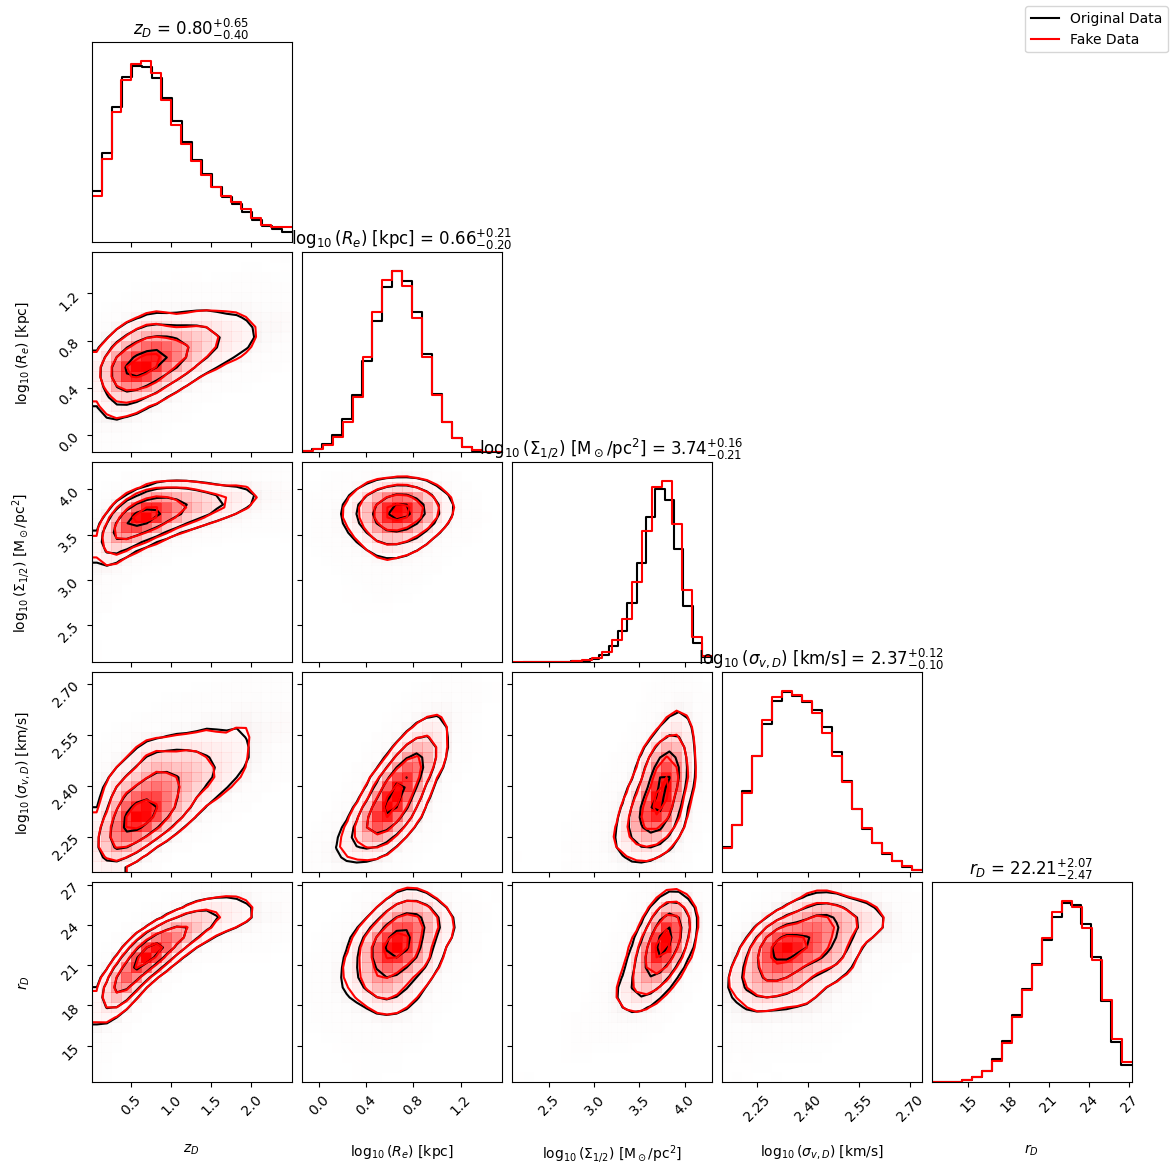

In [5]:
#### SANITY CHECK with the original data

fake_data_org = generate_fake_catalog(
    source_table=GGL_data_table,
    num_samples=len(GGL_data_table),
)

print("Number of pairs in the original data:", run_pairing_simulation_from_data(
    data=GGL_data_table,
    mag_limit=28,
    num_bins=20,
    threshold_delta_z=0.01,
    verbose=False
))
print("Number of pairs in the fake data:", run_pairing_simulation_from_data(
    data=fake_data_org,
    mag_limit=28,
    num_bins=20,
    threshold_delta_z=0.01,
    verbose=False
))


### corner plot of the fake data vs the original data

data_corner = np.array([
    GGL_data_table['z_D'],
    np.log10(GGL_data_table["R_e_kpc"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["sigma_v_D"]),
    GGL_data_table['mag_D_r']
]).T   

fig_corner = corner.corner(
    data_corner,
    labels=[r'$z_D$', r'$\log_{10}(R_e)$ [kpc]', r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', r'$\log_{10}(\sigma_{v, D})$ [km/s]', r'$r_D$'],
    show_titles=True,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
);

data_corner_fake = np.array([
    fake_data_org['z_D'],
    np.log10(fake_data_org["R_e_kpc"]),
    np.log10(fake_data_org["Sigma_half_Msun/pc2"]),
    np.log10(fake_data_org["sigma_v_D"]),
    fake_data_org['mag_D_r']
]).T

corner.corner(
    data_corner_fake,
    labels=[r'$z_D$', r'$\log_{10}(R_e)$ [kpc]', r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]', r'$\log_{10}(\sigma_{v, D})$ [km/s]', r'$r_D$'],
    show_titles=True,
    smooth=True,
    smooth1d=True,
    fig=fig_corner,
    color= 'red',
    plot_datapoints=False,
    
);

fig_corner.legend(['Original Data', 'Fake Data'])

In [6]:
fake_data_org

z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0.5055989132578623,2.05663626807874,0.8269180721163933,211.22095211256976,304179055674.6463,26.02276602072972,26.085052671027903,26.25318629184808,25.8247155905868,25.68858625415756,19.744324684695933,20.615737355898048,22.10976152780664,19.367614758496615,19.181417437548173,0.5276974780100651,0.11908883089132151,0.05792893871279666,0.13088645694336554,2,3.2977959749551733,4650.982825911674,23.174808003124348
0.90896873400619,4.186485248967459,0.9952912697943979,245.4798425911865,461611165122.3722,26.171896739811633,26.253496181171606,27.23145456012392,26.045270126308566,26.00579832444348,21.720369804264994,22.70132336012839,23.989401396732504,20.886474760676535,20.53509997368416,0.374644660991766,0.2618217829730558,0.0067252132038804185,0.2626050794395425,2,2.899135152243125,10600.868873040876,24.266534636330647
1.5633240030816469,4.040910255611108,0.9523615320920966,296.632798984032,755832466578.6431,24.683844002438878,24.707834091002592,25.537310415083446,24.556494417556525,24.527846663021467,24.25357157518138,25.999860272389434,26.854010553524052,23.308766957338904,22.78873847282166,0.819069526108852,0.5301768069317583,0.11663734108114698,0.5449861504239006,2,6.9308881060311895,6552.625392598186,29.102977376590573
0.6367288905279522,2.992468842373762,0.5176733139706133,168.1573945183235,137958165280.5517,26.000642767727772,26.125036735172536,26.13878856647746,25.94491223783419,25.99507723503065,21.151904378164513,22.173511125458727,23.299171532300196,20.848651385395303,20.508780144211013,0.6112008353608154,-0.05512059577293172,0.043822768059314364,0.06961302102246919,2,4.146042094607108,2752.1325958636344,24.68719315462912
0.6654525350058003,1.6553617371033307,0.5710381067574278,203.36028151239714,270633212951.70242,27.123435243758085,27.33620795971603,27.492190104328632,26.88427626995064,26.60780569102731,20.759281121791243,21.801414483250834,22.75073854191827,20.316570800071172,20.05562302925719,0.3289672196831478,-0.0858640467375081,-0.3899543350988676,0.4014412032245963,2,2.3005713778788466,6481.559903802846,22.92202653987134
0.1907104283688128,2.5212803358160927,0.7716223669284081,175.81570247680935,171557752929.68787,25.65013959658097,25.791819411835526,25.84512333994822,25.707840521361206,25.65116609277952,17.605679612765975,18.061938674647095,19.080855155603253,17.370984496748743,17.197429154860274,0.978356308236926,0.06482461459124923,0.12447202748335713,0.14095537415983236,2,3.141394452122152,1841.0453094105085,21.492636812786763
0.7934605252153424,1.9678919917726314,0.564948410205353,207.9253303406209,290268952157.8476,27.104499303213267,27.154686364254303,27.339501658868212,26.919690144423047,26.805738239042395,21.654043677228874,22.873262102352992,24.741481114912034,20.951946775875495,20.655116605979202,0.7408637989784534,-0.10493957375039517,-0.0107266296839644,0.105467362567968,2,5.517852385622545,3250.686616890351,26.564151050828887
0.7343630175287704,3.105739583949204,0.6914759763403524,200.73241942325643,251176833984.72745,25.221498157312773,25.45638310364715,25.865098156257172,24.993435544718746,24.90121651057246,21.201580208509586,22.466548033007562,23.95460469934095,20.695557134497196,20.382377582331475,0.5212613459381213,0.025460220578884352,-0.0015457265115995415,0.028914525518566457,2,3.727621313351587,4737.961294708116,24.960550730998744
1.7118872438084984,3.038262358302899,0.7752115782613656,322.7399954789334,1002953979915.6744,27.63073574600057,27.78650768280568,27.91943699096415,27.523487002303984,27.563312447650983,24.375736741409536,25.103134904429343,25.33751110695304,23.45688887646995,22.98436090238876

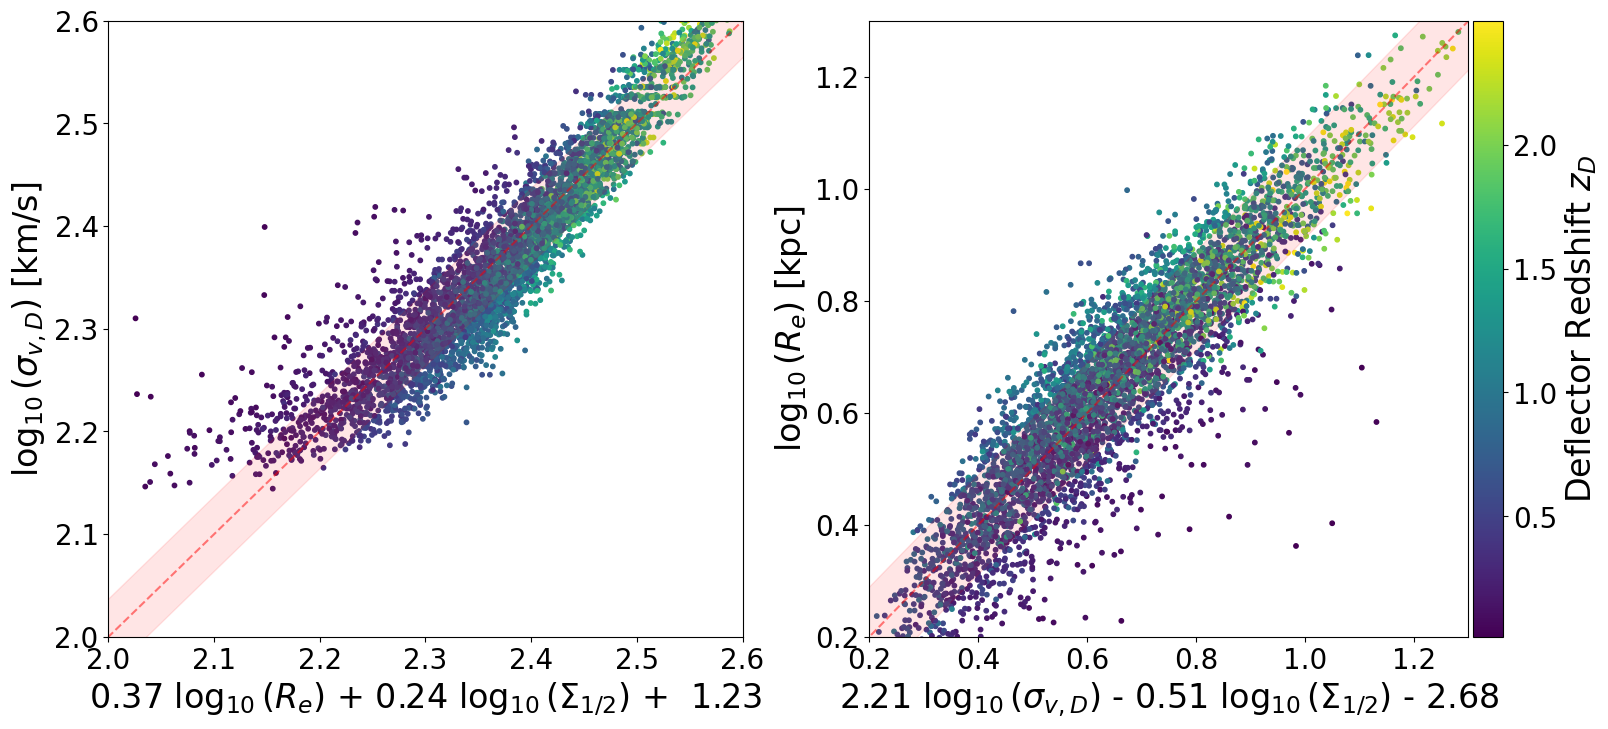

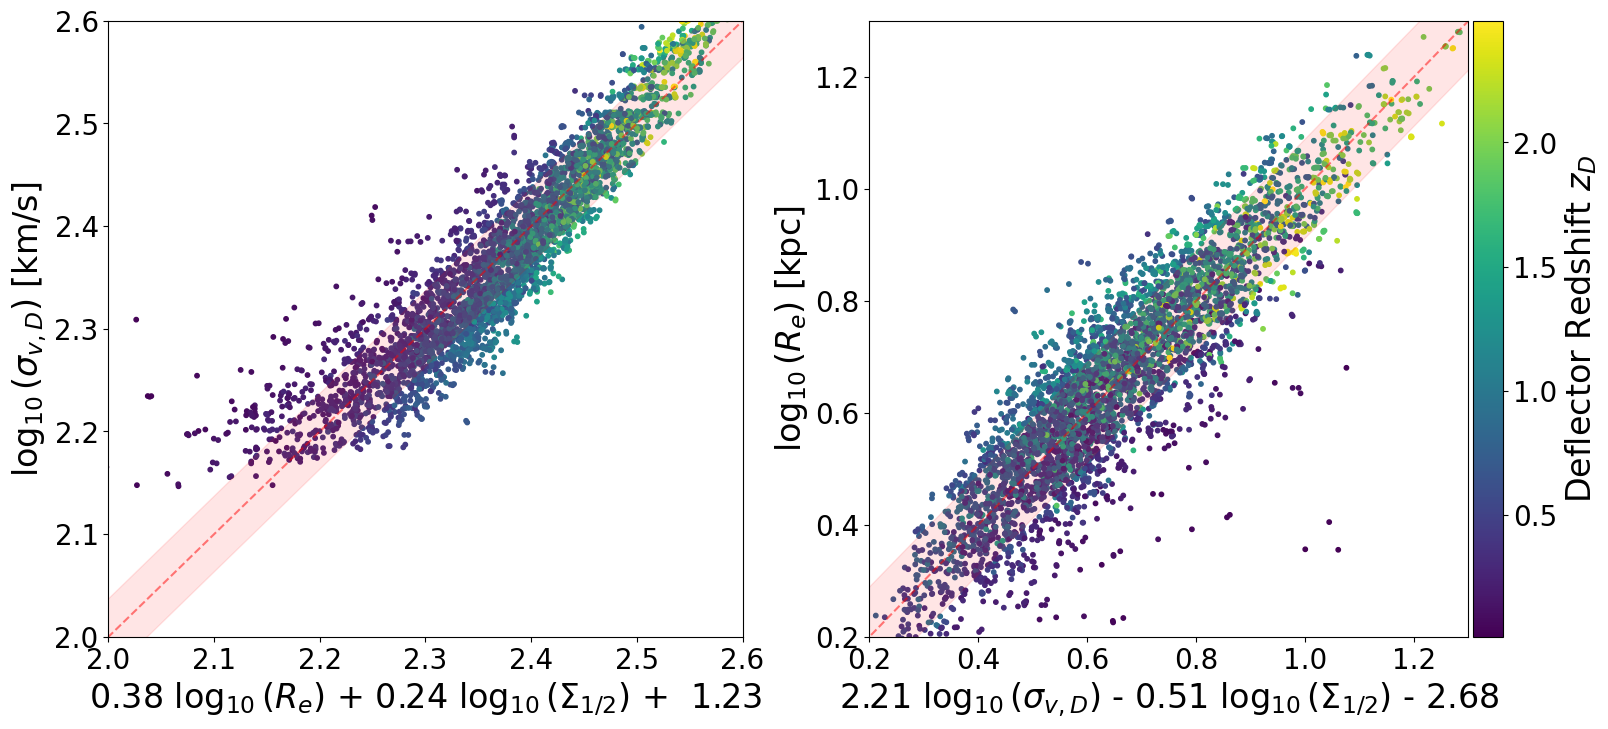

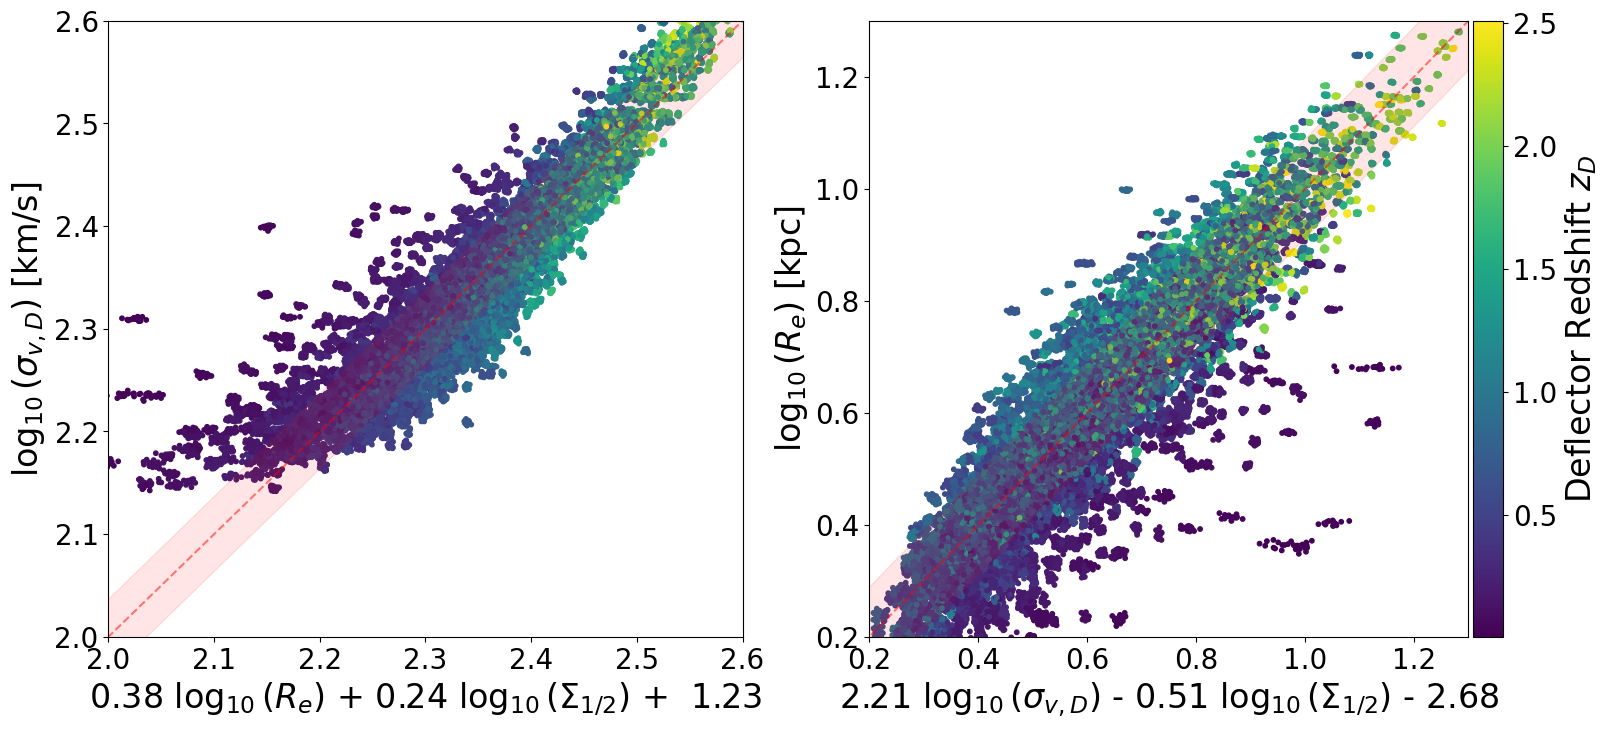

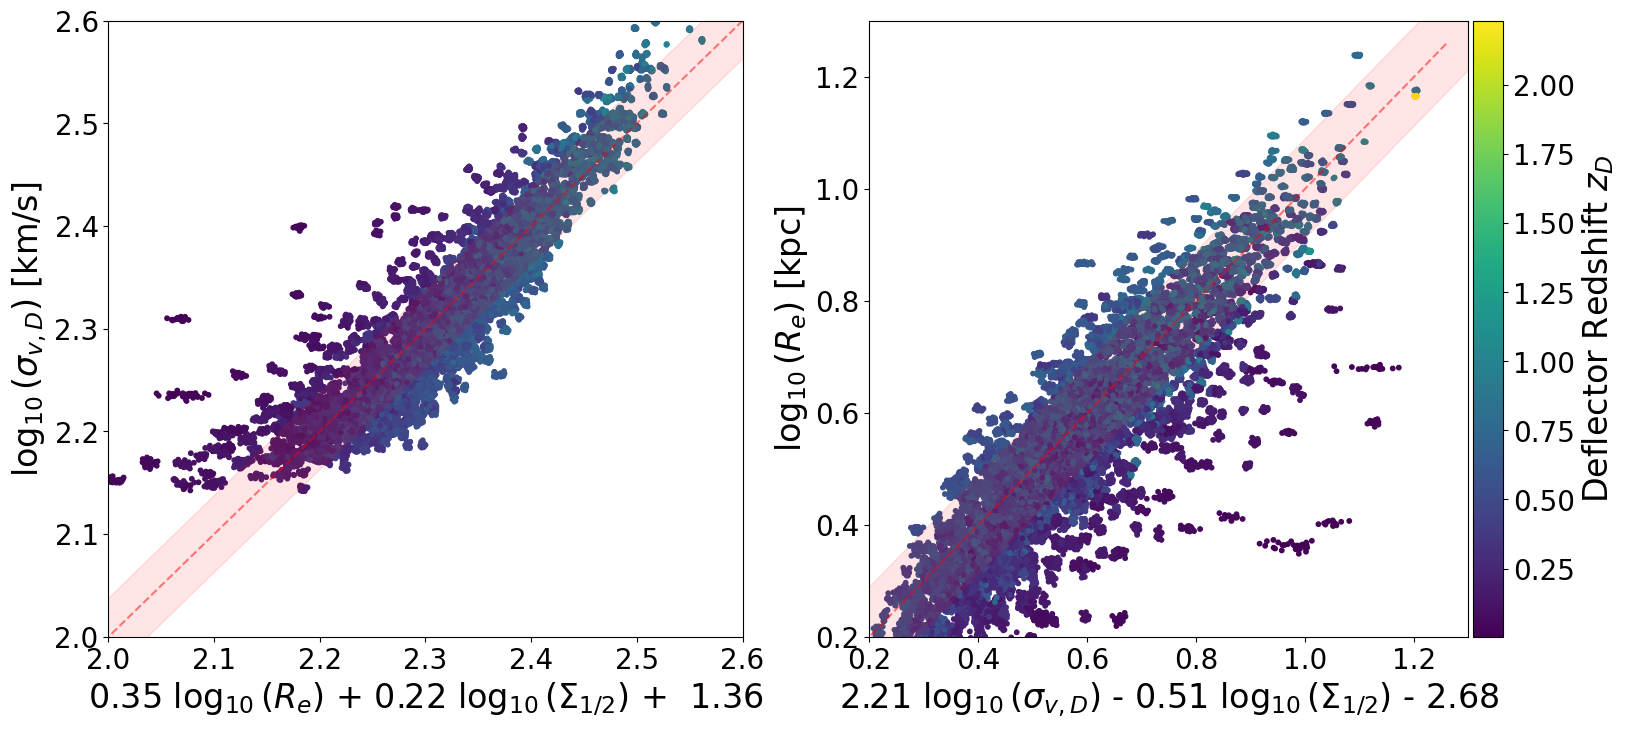

In [8]:
# MFP for the original data and the fake data

larger_area_fake_data = generate_fake_catalog(
    source_table=GGL_data_table,
    num_samples=100000,  # Increase the number of samples for larger area
)

larger_area_fake_data_bright = larger_area_fake_data[larger_area_fake_data['mag_D_r'] < 22]

for data_table in [GGL_data_table, fake_data_org, larger_area_fake_data, larger_area_fake_data_bright]:
    # fit the MFP
    coeffs_MFP = fit_plane(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"])
    )

    # find the scatter
    scatter_MFP = find_scatter(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"]),
        coeffs_MFP,
        return_fit=False
    )

    # side-by-side plot of the two fundamental planes
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # sigma_v fundamental plane
    axs[0].scatter(
        coeffs_MFP[0] * np.log10(data_table["R_e_kpc"]) + 
        coeffs_MFP[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP[2],
        np.log10(data_table["sigma_v_D"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[0].set_xlabel(f'{coeffs_MFP[0]:.2f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_MFP[1]:.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ + ' + f' {coeffs_MFP[2]:.2f}')
    axs[0].set_ylabel(r'$\log_{10}(\sigma_{v, D})$ [km/s]')
    # axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

    # Plot the fitted plane with a faded scatter
    # y = x
    axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
    y_faded = x_faded
    axs[0].fill_between(x_faded, y_faded - np.std(scatter_MFP),
                        y_faded + np.std(scatter_MFP), color='red', alpha=0.1)

    # R_e fundamental plane
    scatter_plot = axs[1].scatter(
        coeffs_MFP_alt[0] * np.log10(data_table["sigma_v_D"]) + 
        coeffs_MFP_alt[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP_alt[2],
        np.log10(data_table["R_e_kpc"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[1].set_xlabel(f'{coeffs_MFP_alt[0]:.2f} ' + r'$\log_{10}(\sigma_{v, D})$ ' + f'{'+' if coeffs_MFP_alt[1] > 0 else '-'} {np.abs(coeffs_MFP_alt[1]):.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ ' + f'{'+' if coeffs_MFP_alt[2] > 0 else '-'} {np.abs(coeffs_MFP_alt[2]):.2f}')
    axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
    # axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
    # Plot the fitted plane with a faded scatter
    # y = x
    axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
    y_faded = x_faded
    axs[1].fill_between(x_faded, y_faded - np.std(scatter_MFP_alt),
                        y_faded + np.std(scatter_MFP_alt), color='red', alpha=0.1)

    # common colorbar
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scatter_plot, cax=cax)
    cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


    # increase the font size of the labels and title
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xlabel(ax.get_xlabel(), fontsize=24)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24)
        ax.set_title(ax.get_title(), fontsize=24)
        # ax.legend(fontsize=14)

    # cbar label size
    cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=24)

    # cbar tick labels
    cbar.ax.tick_params(labelsize=20)

    axs[0].set_xlim(2, 2.6)
    axs[0].set_ylim(2, 2.6)
    axs[1].set_xlim(0.2, 1.3)
    axs[1].set_ylim(0.2, 1.3)

# save the figure
# fig.savefig(f"../figures/slsim_MFP.pdf", bbox_inches='tight', dpi=300)

In [200]:
arr_num_samples = np.array([1000, 5000, 10000, 25000, 50000, 100000])
mag_depths = np.array([20, 22, 24, 26, 28])
dict_arr_num_pairs = {}

for mag_depth in mag_depths:
    print(f"\n=== Magnitude depth {mag_depth} ===")
    arr_num_pairs = np.array([
        run_pairing_simulation(
            num_samples=num_samples,
            source_table=GGL_data_table,
            mag_limit=mag_depth,
            num_bins=20,
            threshold_delta_z=0.01,
            verbose=True,
            is_source_cut=False  # Apply magnitude limit for source as well
        )
        for num_samples in arr_num_samples
    ])

    dict_arr_num_pairs[mag_depth] = arr_num_pairs



=== Magnitude depth 20 ===

--- Running simulation for 1000 lenses ---
Number of samples after magnitude cut: 204
Finding pairs in the binned data...
Found 11 pairs.

--- Running simulation for 5000 lenses ---
Number of samples after magnitude cut: 946
Finding pairs in the binned data...
Found 321 pairs.

--- Running simulation for 10000 lenses ---
Number of samples after magnitude cut: 1945
Finding pairs in the binned data...
Found 1475 pairs.

--- Running simulation for 25000 lenses ---
Number of samples after magnitude cut: 4916
Finding pairs in the binned data...
Found 9467 pairs.

--- Running simulation for 50000 lenses ---
Number of samples after magnitude cut: 9729
Finding pairs in the binned data...
Found 38898 pairs.

--- Running simulation for 100000 lenses ---
Number of samples after magnitude cut: 19783
Finding pairs in the binned data...
Found 158610 pairs.

=== Magnitude depth 22 ===

--- Running simulation for 1000 lenses ---
Number of samples after magnitude cut: 470
F

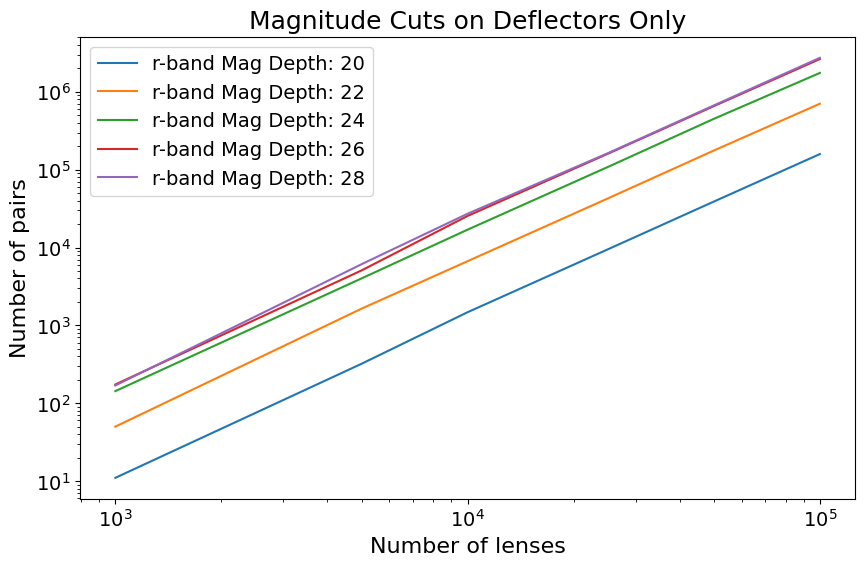

In [201]:
plt.figure(figsize=(10, 6))
for mag_depth, arr_num_pairs in dict_arr_num_pairs.items():
    plt.plot(arr_num_samples, arr_num_pairs, label=f'r-band Mag Depth: {mag_depth}')

plt.xlabel("Number of lenses", fontsize=16)
plt.ylabel("Number of pairs", fontsize=16)
plt.title("Magnitude Cuts on Deflectors Only", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=14)
# plt.xlim(0, 10)
# plt.ylim(0, 0.01)

In [202]:
arr_num_samples = np.array([1000, 5000, 10000, 25000, 50000, 100000])
mag_depths = np.array([20, 22, 24, 26, 28])
dict_arr_num_pairs = {}

for mag_depth in mag_depths:
    print(f"\n=== Magnitude depth {mag_depth} ===")
    arr_num_pairs = np.array([
        run_pairing_simulation(
            num_samples=num_samples,
            source_table=GGL_data_table,
            mag_limit=mag_depth,
            num_bins=20,
            threshold_delta_z=0.01,
            verbose=True,
            is_source_cut=True  # Apply magnitude limit for source as well
        )
        for num_samples in arr_num_samples
    ])

    dict_arr_num_pairs[mag_depth] = arr_num_pairs



=== Magnitude depth 20 ===

--- Running simulation for 1000 lenses ---
Number of samples after magnitude cut: 0

--- Running simulation for 5000 lenses ---
Number of samples after magnitude cut: 0

--- Running simulation for 10000 lenses ---
Number of samples after magnitude cut: 0

--- Running simulation for 25000 lenses ---
Number of samples after magnitude cut: 0

--- Running simulation for 50000 lenses ---
Number of samples after magnitude cut: 0

--- Running simulation for 100000 lenses ---
Number of samples after magnitude cut: 0

=== Magnitude depth 22 ===

--- Running simulation for 1000 lenses ---
Number of samples after magnitude cut: 1

--- Running simulation for 5000 lenses ---
Number of samples after magnitude cut: 1

--- Running simulation for 10000 lenses ---
Number of samples after magnitude cut: 6
Finding pairs in the binned data...
Found 0 pairs.

--- Running simulation for 25000 lenses ---
Number of samples after magnitude cut: 11
Finding pairs in the binned data...

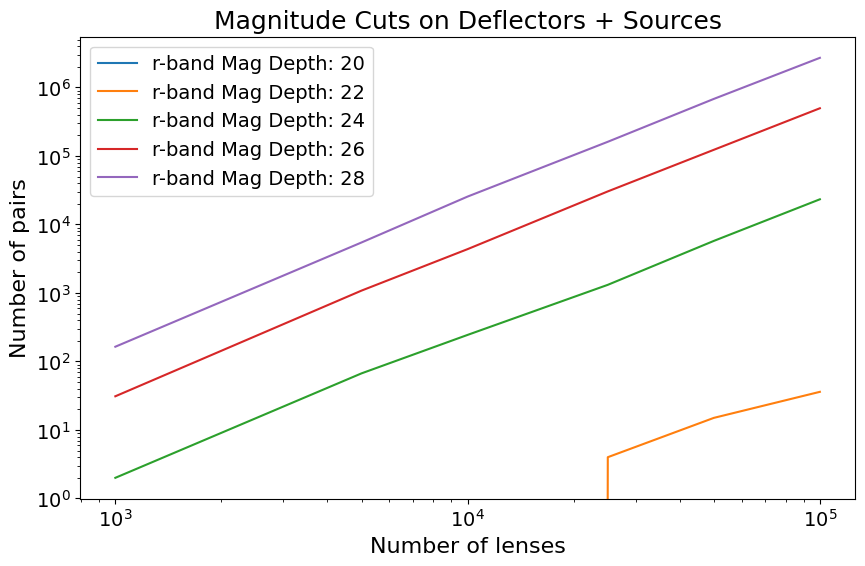

In [203]:
plt.figure(figsize=(10, 6))
for mag_depth, arr_num_pairs in dict_arr_num_pairs.items():
    plt.plot(arr_num_samples, arr_num_pairs, label=f'r-band Mag Depth: {mag_depth}')

plt.xlabel("Number of lenses", fontsize=16)
plt.ylabel("Number of pairs", fontsize=16)
plt.title("Magnitude Cuts on Deflectors + Sources", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=14)
# plt.xlim(0, 10)
# plt.ylim(0, 0.01)

In [164]:
def estimate_plane_scatter(x_data, y_data, a, b, c, a_err, b_err, c_err):
    # 1. Calculate the predicted z-values on the plane for each (x, y) point
    z_predicted = a * x_data + b * y_data + c

    z_data = (np.random.normal(a, a_err, len(x_data)) * x_data +
              np.random.normal(b, b_err, len(y_data)) * y_data +
              np.random.normal(c, c_err, len(x_data)))

    # 2. Calculate the residuals (the vertical distance from each point to the plane)
    residuals = z_data - z_predicted

    # 3. Calculate the scatter, which is the standard deviation of the residuals
    scatter = np.std(residuals)

    return scatter, residuals

scatter, residuals = estimate_plane_scatter(
    np.log10(fake_data_org["R_e_kpc"]),
    np.log10(fake_data_org["Sigma_half_Msun/pc2"]),
    a = 1.52,
    b = -1.17,
    c = 0.45,
    a_err = 0.17,
    b_err = 0.06,
    c_err = 0.02
)
print(f"Scatter of the plane: {scatter:.2f}")

Scatter of the plane: 0.25 dex


In [212]:
# LSST 1-year depth cuts for both deflector and source

GGL_data_table[
    (GGL_data_table['mag_D_g'] < 25.0) &
    (GGL_data_table['mag_D_r'] < 24.7) &
    (GGL_data_table['mag_D_i'] < 24.0) &
    (GGL_data_table['mag_D_z'] < 23.3) &
    (GGL_data_table['mag_D_y'] < 22.1) &
    (GGL_data_table['mag_S_g'] < 25.0) &
    (GGL_data_table['mag_S_r'] < 24.7) &
    (GGL_data_table['mag_S_i'] < 24.0) &
    (GGL_data_table['mag_S_z'] < 23.3) &
    (GGL_data_table['mag_S_y'] < 22.1)
    ]

lens_id,z_D,z_S,theta_E,sigma_v_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
82,0.08735512547649388,0.5971974632236927,0.687975434202141,169.2085871745265,22.439457803688885,23.15087568953778,24.03346866342886,22.182589191486226,21.9688742062577,15.875831404338822,16.26749545424725,17.086575998506508,15.619552939728532,15.468015497746624,1.0283639136797138,0.00040200399439713143,-0.0008182404725643246,0.0009116603986427941,2,1.6810956292235513,1937.715992226131,19.609325277110152
100,0.23074491088722293,1.4071222674920374,0.7649091329217595,184.7857472811958,21.326920051098924,21.591483214619842,21.761851073627156,21.165344493816313,20.764156753044823,17.85931038571798,18.324949768743526,19.462281875474797,17.635051398687242,17.43477457162683,0.919419427805336,0.0028001618733005658,-0.001391095593048136,0.0031266681092952733,2,3.386484528259163,2039.274601830494,21.738739736151423
104,0.6715056515192871,1.2512825715009508,0.9911299157788354,302.8857169817819,22.04053043535706,22.518918078410774,23.043327277704503,21.45354761680463,21.00898785987002,19.657571510612524,20.75063220874313,21.840736587958784,19.211148609647704,18.89078356108558,0.7604467385540495,0.16029318890903266,-0.014475604406789539,0.1609454862168203,2,5.342580505635573,6649.213804424573,23.70704665608565
384,0.5960298052753842,1.6403268290874589,0.5810898594676107,196.01176335584879,22.124153487134507,22.363079312190834,22.536665968366897,21.937799453188426,21.716754366750024,20.45777943959129,21.417491650491534,22.442787079056835,20.101580715105825,19.835137484723383,0.5053954639221787,-0.05894124133380754,0.007019278141205365,0.059357730714657095,2,3.36840413245183,4155.6802917369705,23.442755946530816
723,0.21070793061460721,1.2260937696021357,0.6908374406968036,175.77097020510715,22.57296510467153,22.923680843783405,23.353786193951716,22.084125231777275,21.71955678408452,17.73290611112063,18.19998831226125,19.164551922284364,17.500848799165748,17.299758122017447,0.6259868311570767,-0.038085654456716724,-0.041492977522055476,0.05632214714517041,2,2.1511195122300384,2736.1930064792086,20.60599657832327
810,0.3506223145957063,1.166906800619513,0.8973697627969562,222.8181794705175,22.40949527828861,22.709496338760218,22.939285612607343,21.82816134659329,21.617109875963415,18.450807702186907,19.029003821710695,20.4972408468021,18.131519097018874,17.943679061994303,0.685227338693422,0.034052972379603454,0.07977307303335984,0.08673723600087681,2,3.3887726667671463,4049.374545072145,22.132604651013047
831,0.19712230112433057,1.3446616536979246,0.8971941880779685,196.9711810366433,21.66156354678572,21.92920510937448,22.147798736535314,21.41871636951415,21.016296178426316,17.194231012741913,17.724695715276358,18.705262083806563,16.906614790793373,16.671595392733334,0.9890324737502244,-0.023787306898044976,-0.05853068124232078,0.06317971680968458,2,3.226554728340021,2164.909300648168,21.144954888647014
1148,0.801045887277281,2.1150271690455447,0.834231472750769,246.1040939509003,21.798046119721704,21.891052665858624,22.090392228522283,21.600047519650147,21.4263624612925,21.026596119549417,22.22132757035613,23.870589833234824,20.342196130997387,20.074433414266103,0.6017633624740435,0.02190220935813274,0.05933060789798635,0.06324419189389709,2,4.520252346975501,5568.983192537835,25.223840251679015
1426,0.5148353763354325,0.9219594261873109,0.7248747491588968,258.16878213929607,21.536170462283053,22.17559737165017,22.52731081112676,21.208994011811882,21.080223551313978,19.16833978646201,20.041238834012933,21.553693626133725,18.79081706089435,18.570986052191667,1.2113955580688642,-0.1070560957156274,-0.06032079082138903,0.12288045180251961,2,7.509605680716302,3239

In [213]:
# LSST 10-year depth cuts for both deflector and source

GGL_data_table[
    (GGL_data_table['mag_D_g'] < 27.4) &
    (GGL_data_table['mag_D_r'] < 27.5) &
    (GGL_data_table['mag_D_i'] < 26.8) &
    (GGL_data_table['mag_D_z'] < 26.1) &
    (GGL_data_table['mag_D_y'] < 24.9) &
    (GGL_data_table['mag_S_g'] < 27.4) &
    (GGL_data_table['mag_S_r'] < 27.5) &
    (GGL_data_table['mag_S_i'] < 26.8) &
    (GGL_data_table['mag_S_z'] < 26.1) &
    (GGL_data_table['mag_S_y'] < 24.9)
    ]

lens_id,z_D,z_S,theta_E,sigma_v_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
1,1.1676192009673254,2.838231941243875,0.5428598143754139,215.84729996869848,24.22762289989987,24.307252461915994,24.330966194829777,24.19614120355442,24.25840995562706,23.4402925996813,24.481996698219838,25.35590571629431,22.647451548717875,21.931126586377424,0.2833098895986966,0.01249637671998382,-0.11601750873715334,0.11668856741216427,2,2.339785570397245,9636.754519164577,25.086016539203026
9,1.4344426010242832,3.3913293854779867,0.5917633700616524,236.23512797251792,25.146808126425913,25.263180154304333,25.6901955123036,25.015635603240714,24.89053659004055,23.93620889885314,24.88380428755002,25.042241502152706,23.340626025707557,22.733446307645544,0.7171255056682229,0.014362056538236165,-0.007488514864659662,0.016197114646927736,2,6.056435322817009,4854.230746899351,26.77850909037691
14,0.6712953654357607,3.446367655428871,0.606008207643604,181.0039568041827,24.513330945151022,24.536635853035985,24.901373445715958,24.44910004871348,24.355020424913338,21.255910199292273,22.45700073041457,23.957487759104083,20.811639399117496,20.50390735354336,0.502827247567776,0.14455459282908228,-0.2439492119384304,0.2835617187022307,2,3.532191944348612,4012.129743774339,24.948073424639347
15,1.7006898400583776,4.822120174490979,0.526119460772455,217.42296535943066,24.450774537799578,24.71916629410948,26.83159686394109,24.48082711085041,24.36871046196421,24.314892274240336,24.534660276594472,24.67872126831743,23.918246470949846,23.580441313960726,0.706367505537572,0.020557478505004938,0.1483837536406445,0.14980102892494168,2,5.979681820300691,4814.984003524597,26.38431455252395
24,0.8101799804456613,2.368854501537108,0.7993402880987126,234.61685181055714,24.75229447536138,24.90400071891127,25.149458154723753,24.65529390204579,24.431725972104275,21.045249574657024,22.036160375900682,22.935807415358905,20.41287182714839,20.1824300480998,0.6953596224457526,-0.0004258642128313169,-0.0005094124521542403,0.0006639739258285925,2,5.243353702125809,4484.953678174041,24.61021208786431
29,1.1025875755517551,4.031525208097201,1.2095205521637802,287.6274278090039,24.285813096051765,24.243087263107608,25.02983759904423,24.162022386608196,24.189511413532575,22.281370636241753,23.21223706492234,24.159751451396936,21.399294247758178,20.762343260458714,0.5922447072058435,-0.022051313746805024,0.082665193372795,0.08555579836178039,2,4.84256545587264,9344.13894088736,25.487700859120103
34,0.38345094833667215,2.5532221905201937,0.9551383243202309,210.65548898744012,24.732900105236986,24.984109739692308,25.21004834277813,24.622288089837156,24.375213474528742,18.89638626580711,19.507872039603434,20.956170027947536,18.532051814741592,18.332924738675835,0.6920930970327459,0.2040008963207995,0.10095300401463,0.22761343264242445,2,3.6231031600482555,3654.0941357562447,22.65056221981729
36,1.3623126202609124,3.9354379193739795,1.6618507801268538,368.4217883021555,24.807688980411804,24.86078061372732,25.56911430210721,24.615310620896757,24.54709437763111,22.212945077054332,22.982994001659346,23.162127508164982,21.69794327715771,20.98033846632647,1.1843810049834493,0.05038526308137143,0.012032788077647818,0.0518021498077116,2,9.966646646931496,7599.864245729349,26.004638913440782
37,1.063091965850194,3.3133948986183075,0.6422378675242981,215.44236009347333,23.278456244626653,23.370417932323498,23.632409828688218,23.195504135531074,23.132754151573778,22.626899617788546,23.25078233579365,23.673000738951927,21.828757737367013,21.339600869286024,0.47889333792064875,-0.006646459617250302,0.008317800398322677,0.010647123034419951,2,3.887620520607209,5996.416232924403,24.530610528020592


### Predict Number of Pairs from LSST and 4MOST

In [71]:
def run_pairing_simulation_from_data(data, mag_limit=22, threshold_rel_delta_z=0.01, 
                                     verbose=True, is_source_cut=False):
    """
    Computes the number of pairs on the fundamental plane.

    Args:
        data (astropy.table.Table): The original data table to resample from.
        mag_limit (float): The magnitude limit to apply to the catalog.
        num_bins (int): The number of bins to use for pairing in the R_e-Sigma plane.
        threshold_rel_delta_z (float): The relative redshift difference threshold for a valid pair.

    Returns:
        int: The total number of valid pairs found.
    """
    if verbose:
        print(f"\n--- Running simulation for {len(data)} lenses ---")

    data = data.copy()

    # Step 1: Use the data
    data = data[data['mag_D_r'] < mag_limit] # Apply magnitude limit for deflector
    if is_source_cut:
        data = data[data['mag_S_r'] < mag_limit] # Apply magnitude limit for source
    if verbose:
        print(f"Number of samples after magnitude cut: {len(data)}")
    if len(data) < 2:
        return 0

    # Step 4: Bin the data and find pairs
    x = np.log10(data["R_e_kpc"])
    y = np.log10(data["Sigma_half_Msun/pc2"])

    # remove infinite and NaN values
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    data = data[mask]

    # determine the bin_widths based on the data's stddev
    x_std = np.nanstd(x)
    y_std = np.nanstd(y)
    print(f"x_std: {x_std}, y_std: {y_std}")
    x_width_bin = 3.5 * x_std / (len(x)**(1/(2+2)))
    y_width_bin = 3.5 * y_std / (len(y)**(1/(2+2)))
    print(f"Using bin widths of {x_width_bin:.2f} in x and {y_width_bin:.2f} in y for pairing.")
    num_bins_x = int((np.nanmax(x) - np.nanmin(x)) / x_width_bin) + 1
    num_bins_y = int((np.nanmax(y) - np.nanmin(y)) / y_width_bin) + 1
    print(f"Using {num_bins_x} bins in x and {num_bins_y} bins in y for pairing.")

    x_bins = np.linspace(np.nanmin(x), np.nanmax(x), num_bins_x)
    y_bins = np.linspace(np.nanmin(y), np.nanmax(y), num_bins_y)

    total_pairs = 0
    
    # Iterate through each bin on the plane
    if verbose:
        print("Finding pairs in the binned data...")
    for i in range(len(x_bins) - 1):
        for j in range(len(y_bins) - 1):
            mask = (
                (x >= x_bins[i]) & (x < x_bins[i + 1]) &
                (y >= y_bins[j]) & (y < y_bins[j + 1])
            )
            
            # Need at least 2 points to form a pair
            if np.sum(mask) < 2:
                continue
            
            data_points_in_bin = data[mask]
            
            for lens1, lens2 in combinations(data_points_in_bin, 2):
                # check z_lens < z_source
                if lens1['z_D'] >= lens2['z_S'] or lens2['z_D'] >= lens1['z_S']:
                    continue
                if 2 * np.abs(lens1['z_D'] - lens2['z_D']) / (lens1['z_D'] + lens2['z_D']) <= threshold_rel_delta_z:
                    total_pairs += 1
    if verbose:
        print(f"Found {total_pairs} pairs.")

    return total_pairs

In [77]:
data = generate_fake_catalog(
    source_table=GGL_data_table,
    num_samples=int(len(GGL_data_table)*20000/50),  # Scale to 20000 deg^2 from 50 deg^2
)

lsst_10_yr_coadd_mag_depth_mask = ((data['mag_D_g'] < 27.4) & (data['mag_S_g'] < 27.4) &
                        (data['mag_D_r'] < 27.5) & (data['mag_S_r'] < 27.5) &
                        (data['mag_D_i'] < 26.8) & (data['mag_S_i'] < 26.8) &
                        (data['mag_D_z'] < 26.1) & (data['mag_S_z'] < 26.1) &
                        (data['mag_D_y'] < 24.9) & (data['mag_S_y'] < 24.9)
                        # (data['z_S'] < 1.5) # 4MOST limit
)

lsst_1_yr_coadd_mag_depth_mask = ((data['mag_D_g'] < 26.0) & (data['mag_S_g'] < 26.0) &
                        (data['mag_D_r'] < 25.7) & (data['mag_S_r'] < 25.7) &
                        (data['mag_D_i'] < 25.0) & (data['mag_S_i'] < 25.0) &
                        (data['mag_D_z'] < 24.3) & (data['mag_S_z'] < 24.3) &
                        (data['mag_D_y'] < 23.1) & (data['mag_S_y'] < 23.1)
                        # (data['z_S'] < 1.5) # 4MOST limit
)

lsst_4MOST_mag_depth_mask = (
                        (data['mag_D_r'] < 23.5) & (data['mag_S_r'] < 23.5) &
                        (data['z_S'] < 1.5) # 4MOST limit
)

print("Y1 # lenses:", np.sum(lsst_1_yr_coadd_mag_depth_mask))
print("Y10 # lenses:", np.sum(lsst_10_yr_coadd_mag_depth_mask))
print("4MOST # lenses:", np.sum(lsst_4MOST_mag_depth_mask))

# num of pairs


print("4MOST # pairs:", run_pairing_simulation_from_data(
    data=data[lsst_4MOST_mag_depth_mask],
    mag_limit=23,
    threshold_rel_delta_z=0.01,
    verbose=True,
    is_source_cut=True
))

Y1 # lenses: 49914
Y10 # lenses: 428343
4MOST # lenses: 10469

--- Running simulation for 10469 lenses ---
Number of samples after magnitude cut: 5801
x_std: 0.13873796385688444, y_std: 0.15221034742359138
Using bin widths of 0.06 in x and 0.06 in y for pairing.
Using 11 bins in x and 9 bins in y for pairing.
Finding pairs in the binned data...
Found 402654 pairs.
4MOST # pairs: 402654


In [ ]:
# plot all three samples
